# Using a Neural Network to Detect Galaxies in an Image, and Finding Their Ellipticities

Dark matter can be detected through its gravitational interactions with surrounding observable matter. Gravitational lensing, which is when light from a source is bent by a large mass in between the source and the observer, is one way that dark matter can be identified and traced. There are many observed examples of strong lensing, when, for example, a background galaxy is bent around a galaxy cluster with a huge DM halo into an arc or impressive ring. These types of lensing events can be very helpful for characterizing DM mass of galaxy clusters - and for studying very distant galaxies, since galaxies which are lensed are also amplified in brightness.

Another application of lensing is weak lensing - when a smaller mass, like the mass of one large galaxy or a dark matter filament, distorts all light around it at a barely-noticeable level, and in a preferential direction. This can be seen as a small non-randomness of ellipticites of background galaxies. Statistical analyses of thousands of galaxies are required to reveal weak lensing events, and the signal is usually tiny (on the order of 1%, much smaller than typical ellipticites of background galaxies). Deep-field observations with large observational areas are the best for measuring cosmic shear, where many high-redshift galaxies with measurable ellipticies are visible. 

However, finding galaxies in these images and measuring their ellipticities can be tedious due to the enormous number of galaxies in one image. Using machine learning to locate and classify galaxies in an image is one way to mitigate time spent analyzing deep-field images. In this project, I create a neural network which finds galaxies in an image, and then estimates the ellipticity of each galaxy that the NN detected.

# AI and Tutorial Statements

Since object detection is a different problem than just object classification, I had to use a different type of neural network from the type we covered in class/the textbook. I searched for an appropriate object detection model within the same package that we were using, Keras, and found the KerasCV (CV stands for computer vision, meaning it analyzes images) YOLOv8 model (You-Only-Look-Once v8, discussed in depth later). I followed a tutorial for a similar situation: [Efficient Object Detection with YOLOV8 and KerasCV](https://keras.io/examples/vision/yolov8/) written by Gitesh Chawda. Some aspects of this tutorial did not work with my dataset, so I made changes and additions where appropriate. I also went through each line and read documentation where needed to understand what the code was doing; this is documented with comments throughout my code. For the part of the model that finds the ellipticity of galaxies, I used the [GalSim](https://galsim-developers.github.io/GalSim/_build/html/image.html) package. The GalSim package was created for an SDSS data lensing challenge, which I did a project about for a different class. I read the documentation from this package to apply their ellipticity-fitting program, but did not follow a tutorial. 

My utilizations of AI in this project were for interpreting errors. I specifically had some trouble with tensorflow RaggedTensors and putting my data and classifications in the correct format for the YOLOv8 model (like where I turn classification dictionaries into tuples), and I used ChatGPT to help figure out where certain errors were coming from and what I could do to fix them. 

# Imports

Warnings are due to TensorFlow; it can't find my GPU so it is running on my CPU. The warnings don't cause any issues with the model or results.

In [2]:
import os #For grabbing/listing files
from tqdm.auto import tqdm #Shows progress bars for loops
import xml.etree.ElementTree as ET #For creating and reading XML files; for the bounding box annotations

import tensorflow as tf #Tensor operations
from tensorflow import keras #ML package

import keras_cv #Computer vision package
from keras_cv import bounding_box #Package for bounding boxes on images
from keras_cv import visualization #For visualizing train+test images and bounding boxes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/nervoushedgehog/miniconda3/envs/NN/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-23 12:05:23.398561: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-23 12:05:23.413309: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 12:05:23.516046: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 12:05:23.615609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting

# Preparing Input Data

Since I intend to use this NN on images which contain lots of galaxies, my model has to be able to find objects in an image and their rough boundaries. Thus, my training set must contain images of multiple galaxies with bounding boxes for each galaxy. This process is complicated by the presence of other objects, like stars, which may be falsely classified as galaxies. I created a second class for stars in my training set; although I expect that the model will struggle to differentiate between stars and galaxies due to their similarities in appearance, and the relatively low number of stars present in my training images.

To create my training set, I used the custom model creator on the website [RoboFlow](https://roboflow.com/). It allows you to upload your own images and has a convenient interface for drawing and labeling bounding boxes on images. You can then download a file containing all the annotations that you did on your images, as an XML file. This file can be read in and converted to the format needed for Keras using ElementTree. 

I collected all of the images used in [Galaxy Zoo](https://data.galaxyzoo.org/), and ended up classifying stars and galaxies in 99 of them. I also took screenshots of two small portions of the [Hubble Ultra Deep Field](https://esahubble.org/images/heic0611b/), in order to give the model a couple examples of images with many galaxies. I would have included more images like this, but classifing them took a very long time!

In this section, I read in my images and annotations, and then display a selection of images with the bounding boxes I drew for them. 

I set up paths for images and annotations:

In [3]:
#Create a dictionary for classes in training set
class_ids = ['galaxy', "star"]
class_mapping = dict(zip([0, 1], class_ids))

#Get training JPG images and corresponding annotation XML files

#Anotations:
XML_path = "Final_Dataset_//train/Annotations" #Path to folder with XML annotations
xml_files = []
for file in os.listdir(XML_path):
    xml_files.append(os.path.join(XML_path, file)) #Get full path of each XML
xml_files = sorted(xml_files) #Make list of XML file names

#Images:
images_path = "Final_Dataset_/train/Images" #Path to folder with images
jpg_files = []
for file in os.listdir(images_path):
    jpg_files.append(os.path.join(images_path, file)) #Get full path of each image
jpg_files = sorted(jpg_files) #Make list of image file names

I define a function for reading in box data and pairing the boxes with the correct image path:

In [4]:
#Function to read in XML files:
def get_annotation(xml_file):
    #Get and read in the file
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    #Find the image filename in the XML file
    image_name = root.find("filename").text

    #Get the path to the image
    image_path = os.path.join(images_path, image_name)

    boxes = []
    classes = []
    #For each box in the XML file,
    for box in root.iter("object"):
        #Find the class of the box and append it to a list
        cls = box.find("name").text
        classes.append(cls)

        #Find the box coordinates and append them to a list
        bbox = box.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    #Make a list of the correct classifications (0 or 1) for each box
    class_ids = []
    for cls in classes: #For each class:
        for key, classif in class_mapping.items():
            if classif == cls: #For each box classification, if the class is the same (galaxy, star)
                class_ids.append(key) #Append the corresponding key (0 or 1)

    return image_path, boxes, class_ids #Return path to image, list of box coordinates, and list of IDs for each box

I prepare image paths and boxes:

In [5]:
#Make lists for image paths, bounding boxes, and classes of each bounding box
image_paths = []
bbox = []
classes = []

#For each XML file, run the above function to get a list of image paths, boxes, classes
for xml_file in tqdm(xml_files): #Note that the progress bar is from the tqdm package
    image_path, boxes, class_ids = get_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)


100%|███████████████████████████████████████| 101/101 [00:00<00:00, 2675.16it/s]


In [6]:
#keras needs all inputs to be tensors. I will use RaggedTensors, which can have a different length at each row 
#(because there are a different number of boxes in each image, so I need the tensor array to be any length at each row)
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths, dtype=tf.string)

#Make a tensor including all of the input data: boxes, classes for each box, and image paths
data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

E0000 00:00:1745424449.627573    5058 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1745424449.628545    5058 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Again, the warning is from tensorflow. It is unable to find my GPU.

# Training and Testing Splits

After preparing the image paths and boxes, I read in the images, perform training and testing splits, put the data into dictionaries for ease of use, and visualize the data. I use the standard 80-20 split between training and testing. 

In [7]:
split = 0.2 #20% will be testing data, 80% will be training data

num_test = int(len(xml_files) * split) #Number of test images

#Split the dataset
test_data = data.take(num_test)
train_data = data.skip(num_test)

I define a function to read in images and make a nice dictionary out of the images and boxes (which as of right now are contained a large multi-type ragged tensor with no labels)

In [8]:
#Function to read in RGB images, turn them into a tensor
def load_image(image_path):
    image = tf.io.read_file(image_path) #Read in image 
    image = tf.image.decode_jpeg(image, channels=3) #Decode image into tensor array; Channels R, G, B
    return image

#Function to create data dict with images, boxes, and classes for each box
def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    
    #Create dict for bounding boxes+classifications
    bounding_boxes = {"classes": tf.cast(classes, dtype=tf.float32),"boxes": bbox}
    
    #Return dict of images and boxes+classifications
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


Next, I have to create dictionaries containing the actual images.

This is the first hyperparameter of the model: batch size. I use a batch size of 2, meaning the model processes 2 images at a time. In general, this is a small batch size. Typical values are 16-32. I picked this value because my training dataset is small, and my CPU has limited memory. Using a larger batch size would make the model more likely to overfit due to the size of my training set; such a small batch size acts as a regularizer. However, using a batch size that is very small makes model training take much longer - a batch size of 2 is a middle ground. 

In [9]:
batch_size = 2

I create the training dataset:

In [10]:
#Calls func load_dataset for each image path in train_data; reads in the actual image files and creates a dictionary containing all the data
#num_parallel_calls makes the function run parallel on different cores, to speed up the process
train = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE) 

#Turn train back into a ragged tensor, and group images into batches
train = train.ragged_batch(batch_size, drop_remainder=True)

Then I create the testing dataset:

In [11]:
#Calls func load_dataset for each image path in test_data; reads in the actual image files and creates a dictionary containing all the data
#num_parallel_calls makes the function run parallel on different cores, to speed up the process
test = test_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)

#Turn test back into a ragged tensor, and group images by batch size
test = test.ragged_batch(batch_size, drop_remainder=True)

# Data Processing and Augmentation

Next, I augment the training dataset. Since I am working with a small set of training images, this step is espectially important. I use sequential KerasCV layers which randomly flip images horizontally and vertically, shear images in random directions, and randomly resize images on scales from 0.1-2x. These layers also adjust the bounding box coordinates.

In [12]:
#Set up a sequential augmenter, which will provide variations of the input images to the NN
augmenter = keras.Sequential(layers=[keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"), #Flip images horizontally
        keras_cv.layers.RandomFlip(mode="vertical", bounding_box_format="xyxy"), #Flip images vertically
        keras_cv.layers.RandomShear(x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"), #Shear images (for catching lensed galaxies!)
        keras_cv.layers.JitteredResize(target_size=(640, 640), scale_factor=(0.1, 2), bounding_box_format="xyxy"),]) #Resize from 0.1-2x size


First, I augment the training dataset by running the augmenter on each image:

In [22]:
#num_parallel_calls makes the function run parallel on different cores, to speed up the process
train = train.shuffle(batch_size * 4) #shuffle the train dataset
train = train.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

I will augment the testing dataset too, by just resizing it. This will allow us to test how the model finds galaxies of different sizes:

In [23]:
resize = keras_cv.layers.JitteredResize(target_size=(640, 640), scale_factor=(0.5, 2), bounding_box_format="xyxy",)

#Augment training dataset by running the augmenter on each image
#num_parallel_calls makes the function run parallel on different cores, to speed up the process
test = test.shuffle(batch_size * 4) #shuffle the test dataset
test = test.map(resize, num_parallel_calls=tf.data.AUTOTUNE)


# Visualize Training Set

To demonstrate what the training and testing images look like, I show the first batch of images from both, with their bounding boxes and classifications. Some of the images are resized, sheared, or rotated. 

In [24]:
#Function to show images and bounding boxes with labels
def visualize_dataset(inputs):
    #Pick the first batch of images (previously defined as 2 images)
    inputs = next(iter(inputs.take(1)))

    #Grab images and boxes from input dictionary
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]

    #Use the keras visualization module plot_bounding_box_gallery to show images and bounding boxes
    visualization.plot_bounding_box_gallery(images, value_range=(0, 255), rows=1, 
        cols=batch_size, y_true=bounding_boxes, scale=5, font_scale=0.7, bounding_box_format='xyxy', 
        class_mapping=class_mapping)


To visualize the first batch of the training dataset, I run the function:

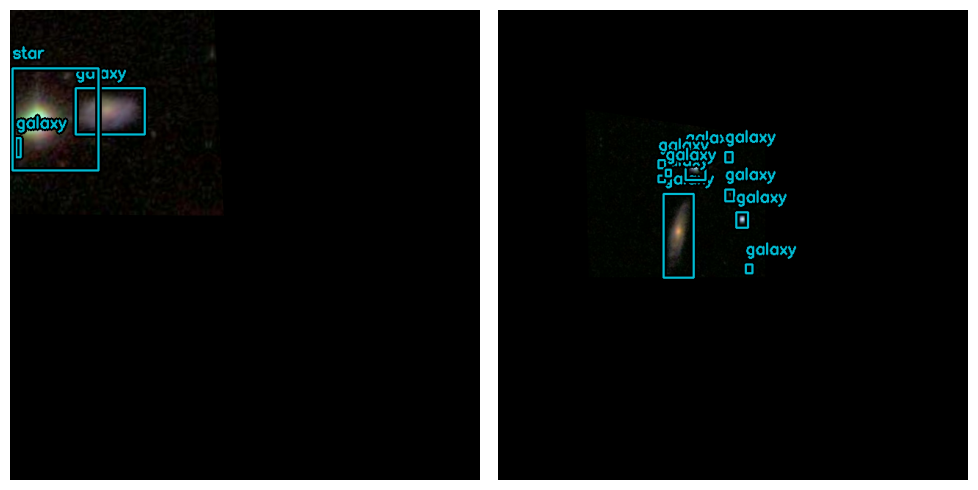

In [26]:
visualize_dataset(train)

Similarly, I can visualize the first batch of the testing dataset:

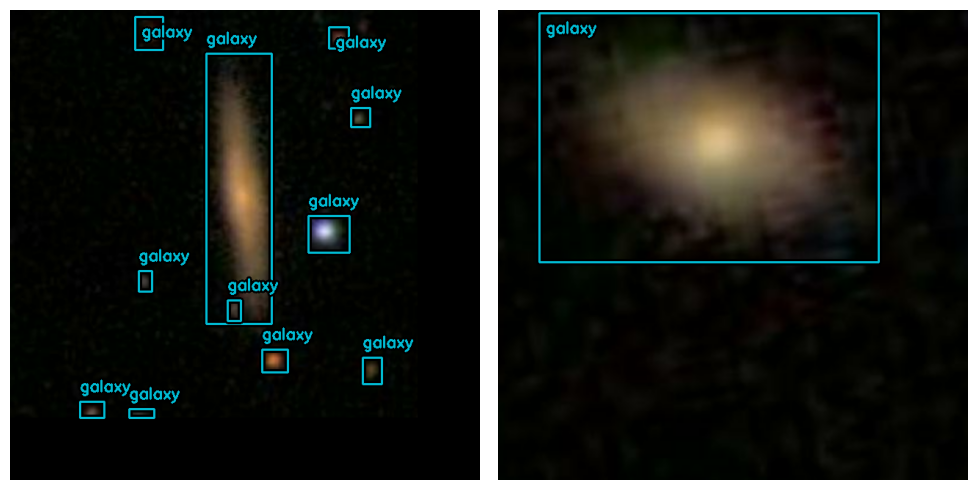

In [28]:
visualize_dataset(test)

# YOLOv8 Model

To detect galaxies in images, I will use the YOLOv8 model. This model is one of the best available and is used in industry. The model has a few parts, including the backbone and the head. The backbone is the part of the model that recognizes features in an image. It is a convolutional neural network with filters that slide across the image, detecting edges, corners, colors/textures, and gradients with increasing complexity. I will use a pretrained backbone based on the COCO (Common Objects in Context) dataset, which was trained to find objects/features in images on a dataset of over 330,000 images. The KerasCV package provides a very convenient way to implement this backbone.

The head, which identifies what objects are in images, will be trained on the galaxy images I provide. The head I will use is called YOLOv8Detector.

Here I define the model backbone. I can print out a summary of the model, showing all of the layers; there are tens of them, including augmenting layers like Resize, Convolution layers, and Padding layers. It also contains BatchNormalization layers, which normalize gradients at each step around 0, which makes the model converge faster and with more stability. However, these layers can cause the exploding gradients problem - I will ensure to prevent this later in my optimization step. In the model summary, you can also see the activation between each of the Conv2D layers.

In total, the model has 5,079,712 trainable parameters (weights and biases).

In [29]:
#I will use a pre-trained backbone, COCO
backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_s_backbone_coco")
backbone.summary()

Model: "yolov8_backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_1_pad          │ (None, None,      │          0 │ rescaling[0][0]   │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_1_conv         │ (None, None,      │        864 │ stem_1_pad[0][0]  │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_1_bn           │ (None, None,      │        128 │ stem_1_conv[0][0] │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_1 (Activation) │ (None, None,      │          0 │ stem_1_bn[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_2_pad          │ (None, None,      │          0 │ stem_1[0][0]      │
│ (ZeroPadding2D)     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_2_conv         │ (None, None,      │     18,432 │ stem_2_pad[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_2_bn           │ (None, None,      │        256 │ stem_2_conv[0][0] │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_2 (Activation) │ (None, None,      │          0 │ stem_2_bn[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack1_c2f_pre_conv │ (None, None,      │      4,096 │ stem_2[0][0]      │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack1_c2f_pre_bn   │ (None, None,      │        256 │ stack1_c2f_pre_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack1_c2f_pre      │ (None, None,      │          0 │ stack1_c2f_pre_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ split (Split)       │ [(None, None,     │          0 │ stack1_c2f_pre[0… │
│                     │ None, 32), (None, │            │                   │
│                     │ None, None, 32)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack1_c2f_pre_0_1… │ (None, None,      │          0 │ split[0][1]       │
│ (ZeroPadding2D)     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack1_c2f_pre_0_1… │ (None, None,      │      9,216 │ stack1_c2f_pre_0… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,089,760 (19.42 MB)

 Trainable params: 5,079,712 (19.38 MB)

 Non-trainable params: 10,048 (39.25 KB)

And I define the model head. The summary shows many similar layers, such as Convolution, Batch normalization, and Padding, and has 12,776,294 trainable weights and biases. The Functional layer is the backbone which I just defined, and Concatenate/Split layers are used to connect/disconnect features of different scales on the image.

In [30]:
#Set up YOLOv8 Model
yolo_model = keras_cv.models.YOLOV8Detector(num_classes=len(class_mapping), bounding_box_format="xyxy", backbone=backbone, fpn_depth=1)

yolo_model.summary()

Model: "yolov8_detector"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, None,     │  5,089,760 │ input_layer_1[0]… │
│ (Functional)        │ None, 128),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 256),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 512)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat (Repeat)     │ (None, None,      │          0 │ functional[0][2]  │
│                     │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_1 (Repeat)   │ (None, None,      │          0 │ repeat[0][0]      │
│                     │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, None,      │          0 │ repeat_1[0][0],   │
│ (Concatenate)       │ None, 768)        │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_co… │ (None, None,      │    196,608 │ concatenate_5[0]… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_bn  │ (None, None,      │      1,024 │ pa_fpn_p4p5_pre_… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre     │ (None, None,      │          0 │ pa_fpn_p4p5_pre_… │
│ (Activation)        │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ split_4 (Split)     │ [(None, None,     │          0 │ pa_fpn_p4p5_pre[… │
│                     │ None, 128),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 128)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, None,      │          0 │ split_4[0][1]     │
│ (ZeroPadding2D)     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, None,      │    147,456 │ pa_fpn_p4p5_pre_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, None,      │        512 │ pa_fpn_p4p5_pre_… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_1 │ (None, None,      │          0 │ pa_fpn_p4p5_pre_… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, None,      │          0 │ pa_fpn_p4p5_pre_… │
│ (ZeroPadding2D)     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, None,      │    147,456 │ pa_fpn_p4p5_pre_

 Total params: 12,797,862 (48.82 MB)

 Trainable params: 12,776,294 (48.74 MB)

 Non-trainable params: 21,568 (84.25 KB)

# Optimize and Compile

Next, I need to set up a framework to optimize the model. I will use the ADAM (Adaptive Moment Estimation) optimizer, which uses an adaptive learning rate and the momentum trick to speed up the convergence of the model. The second hyperparameter that is important to this model is defined here: the intial learning rate for the ADAM optimizer. I will use a value of 0.0001, which is smaller than the value in the tutorial I used. I picked this value because my batch size is low so the gradient descent will be more erratic, and a smaller learning rate will prevent the model from making large jumps and potentially missing a gradient minimum. However, the learning rate will change with ADAM, so if this learning rate is too low and prevents efficient training, the model will adjust itself. I further ensure the model makes small, stable gradient steps by defining a clipnorm of 5 (maximum gradient before all gradients are re-normalized). This will prevent the exploding gradients problem.

Then, I have to compile the model, defining optimization (ADAM) and loss. For loss, I have to consider loss from classifications, and loss from the bounding boxes. I will use a binary cross entropy loss for classifications (there will be a separate loss for each class), and a CIoU (Complete Intersection over Union) loss for boxes. CIoU considers box locations, overlap with training boxes, and dimensions.

In [31]:
#Set up ADAM optimizer
learning_rate = 0.0001
clipnorm = 5 #Maximum gradient, to prevent the exploding gradients problem

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, global_clipnorm=clipnorm)

#Compile model, defining optimization (ADAM )and loss
yolo_model.compile(optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou")


# Training the YOLOv8 Model

First, I finalize the training and testing data and put it into the correct format for the model:

In [32]:
#Finalize training and testing data - Change from a dict to a tuple. Less easy to use, but it is the format the model requires
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(inputs["bounding_boxes"], max_boxes=32) #boxes as a dense tensor, so 0s and 1s are both stored

#finalize training and testing datasets by running the dict_to_tuple function on each image

#num_parallel_calls makes the function run parallel on different cores, to speed up the process
train = train.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
#prefetch speeds up .map by preparing the next dataset while the previous is being processed 
train = train.prefetch(tf.data.AUTOTUNE)

test = test.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test = test.prefetch(tf.data.AUTOTUNE)


When you fit the YOLOv8 model, you add in objects called callbacks. Callbacks are classes that are called during the training process, and are used to control the model between epochs. I will add two: early stopping, and EvaluateCOCOMetricsCallback. Early stopping stops the model during training if the model is not improving, preventing needless time spent training and overfitting. 

EvaluateCOCOMetricsCallback is a custom callback class (written in the cell below) which will, at the end of each training epoch, calculate the MaP (mean Average Precision) of the model using BoxCOCOmetrics, a KerasCV method that calculates scores for box detection models like this one. It then records this score, and saves the model if the score is the best one yet. This ensures that the best model is saved during training. 

The mean Average Precision is the average precision for each class, averaged across all classes. In this case, I have two classes: stars and galaxies.

In [33]:
#Create a callback class for evaluating COCO metrics at each epoch and saving the best model
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        #create data attribute
        self.data = data

        #Calculate COCO metrics and save them as an attribute
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(bounding_box_format="xyxy", evaluate_freq=1e9,)

        #create save path attribute
        self.save_path = save_path

        #create best MaP score attribute
        self.best_map = -1.0

    #At each epoch end, this function is called:
    def on_epoch_end(self, epoch, logs):
        #Reset metrics
        self.metrics.reset_state()

        #For each batch in data:
        for batch in self.data:
            #Grab the image and ground truth boxes/labels
            images, y_true = batch[0], batch[1]

            #Use the model from that epoch to predict boxes/labels for the same image
            y_pred = self.model.predict(images, verbose=0)

            #Calculate COCO metrics for the true and predicted boxes/labels
            self.metrics.update_state(y_true, y_pred)

        #Retrieve and update log with the calculated metrics
        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        #Record MaP score from current epoch
        current_map = metrics["MaP"]

        #If the current MaP score is the best, save the model and replace the object's best_map attribute
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)

        #Return logs dictionary (required for model to use the callback object)
        return logs


The final hyperparameter is defined below: the number of epochs to train the model on. Since I am implementing an early stopping callback, the number of epochs just has to be high enough for the model to obtain its lowest possible loss value. I choose a value of 150, since the early stopping callback typically stops the training at ~140 epochs.

I already trained the model, so I will read it in instead. The commented-out lines are the code I used to train the model.

In [34]:
#Fit model, using 150 epochs, and 2 callback functions: EvaluateCOCOMetricsCallback and EarlyStopping
epoch = 150

#Train model:
#history = yolo_model.fit(train, validation_data=test, epochs=epoch, #history object will contain loss at each epoch
#    callbacks=[EvaluateCOCOMetricsCallback(test, "yolo_model.keras"), 
#               keras.callbacks.EarlyStopping(monitor="MaP", patience=30, mode="max", restore_best_weights=True), ],)

#Save history
#history_df = pd.DataFrame(history.history) 
#history_df.to_csv('history.csv')

#I reload the model because the best model is saved with the COCOMetricsCallback; the last model may not have been the best one
#Load model:
yolo_model = tf.keras.models.load_model('yolo_model.keras')
yolo_model.compile(optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou")
history = pd.read_csv('history.csv')


/home/nervoushedgehog/miniconda3/envs/NN/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


# Evaluate Model and Visualize Results

To evaluate the model, I plot the loss (CIoU for box locations + binary cross entropy for classifications+confidence) for each epoch, and for the training and testing datasets:

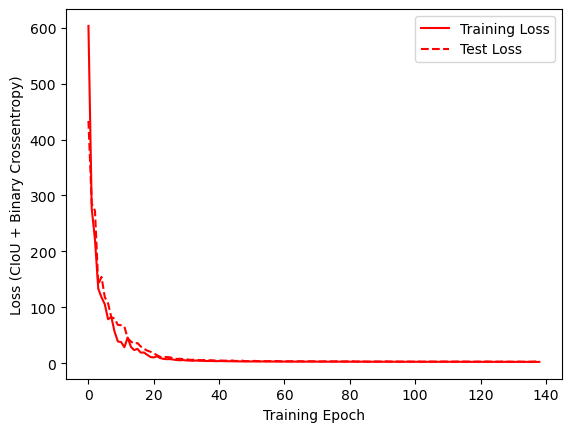

In [36]:
#Plot train and test loss at each epoch
plt.plot(history['loss'], label='Training Loss', color='red')
plt.plot(history['val_loss'], label='Test Loss', color='red', ls='dashed')

plt.xlabel('Training Epoch')
plt.ylabel('Loss (CIoU + Binary Crossentropy)')
#plt.yscale('log')
plt.legend()
plt.show()

From this plot, I see that the loss appears to decrease significantly after about 20 epochs, to a low constant level. This is a good indicator of the performance of the model. In addition, it looks like the test loss is very similar to the training loss at high epochs, indicating that the model is not significantly overfitting the training data. This is likely due to the small batch size. 

I can also plot the mean average precision. Since the MaP is stored in a dataframe as a string (not sure why that happened), I have to convert it:

In [53]:
#Convert the dataframe series into a list
MaP_list = history['MaP'].to_list()
print('Initial format:', MaP_list[0])

MaP_scores = []
for score in MaP_list:
    MaP_score = float(score.split('(')[1].split(',')[0]) #Split the string at the ( and then at the ,
    MaP_scores.append(MaP_score)

Initial format: tf.Tensor(4.783087e-06, shape=(), dtype=float32)


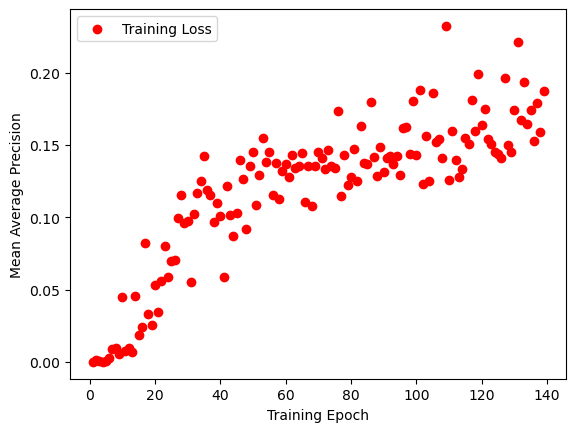

In [54]:
#Plot train and test loss at each epoch
import matplotlib.pyplot as plt

plt.scatter(np.linspace(1, len(MaP_scores), len(MaP_scores)), MaP_scores, label='Training Loss', color='red')

plt.xlabel('Training Epoch')
plt.ylabel('Mean Average Precision')
#plt.yscale('log')
plt.legend()
plt.show()

The MaP score does not appear to be very good as it approaches ~0.2. Howeverm I don't think MaP is directly interpretable like a traditional precision because it includes box locations and sizes, which don't have to be the exact same as the train data, along with detection probabilities (which I will not be using, so again are not very important in my case). Also, the star and galaxy classes are weighted equally, even though there are many more galaxies than stars, and, since stars are more likely to be misclassified as galaxies, this would bring the score down.

Since the model with the best MaP score is saved, it looks like the model at epoch ~110 is the one I loaded in. 

To demonstrate how the model worked, I will show all of the detections in the first batch of test images:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


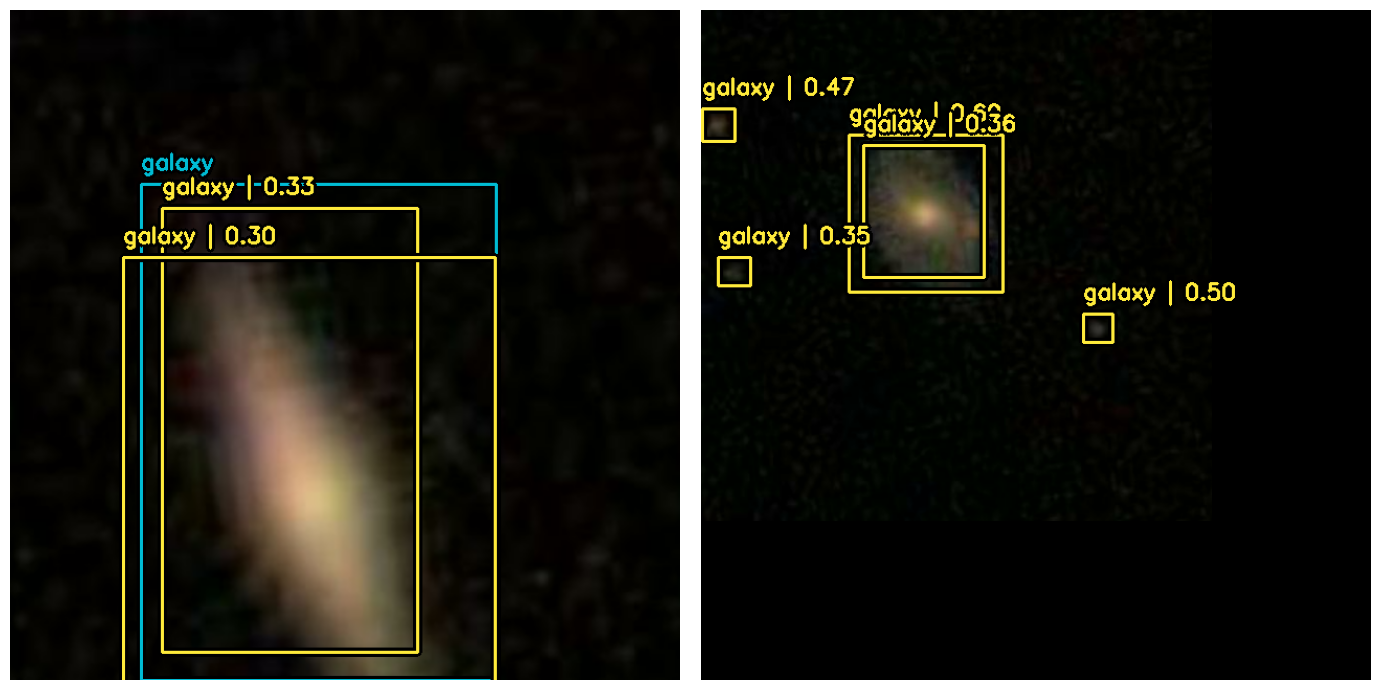

In [57]:
#Function to show galaxy detections in image
def visualize_detections(model, dataset):
    #Collect first batch of ground truth data from dataset
    images, y_true = next(iter(dataset.take(1)))

    #Predict boxes and classifications using trained model
    y_pred = model.predict(images)
    
    #Convert result to a dense tensor, for plot_bounding_box_gallery (so '0' classifications are stored)
    y_pred = bounding_box.to_dense(y_pred)

    #Use the visualization module plot_bounding_box_gallery
    visualization.plot_bounding_box_gallery(images, value_range=(0, 255), bounding_box_format='xyxy', y_true=y_true, y_pred=y_pred,
        scale=7, rows=1, cols=batch_size, show=True, font_scale=0.7, class_mapping=class_mapping)

visualize_detections(yolo_model, test)


From this test set, I notice a few things. First of all, there are a few times when a galaxy is detected more than once. This indicates that something is wrong with the model - however, having more than one detection of each galaxy is not a huge problem, and is something that could be filtered out before continuing to the next step with the results. Another thing I notice is that some boxes do not include the whole galaxy and cut off outer parts. This is most likely due to the fact that some galaxies were cut off in my training images, for example when they were located at the edge of the frame, and would present an issue in ellipticity fitting. To fix this, I could redo my training set and discard any galaxies that were at the edge of the frame - although this would be difficult and would require lots of image cropping. 

# Fit an Ellipse to a Detected Galaxy

Next, I will test the model on a completely new image, and then use GalSim to find the ellipticity of each detected galaxy. 

First, I read in and show the image:

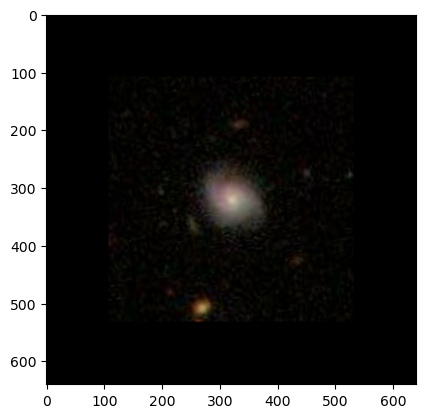

In [58]:
#image_path = 'Test_Galaxy.png'
image_path = 'Test_galaxy.jpg'
#image_path = 'HDF.jpg'

image = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3) #Turn the image into a tensor
image = tf.image.resize_with_crop_or_pad(image, 640, 640) #Crop to 640x640, like our training images (not required)
image_model = tf.reshape(image, (1, 640, 640, 3)) #Reshape into size needed for model
plt.imshow(image) #Show the image

Next, I will use the YOLOv8 model to detect galaxies in this image, and show all detections as yellow boxes:

/home/nervoushedgehog/miniconda3/envs/NN/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_295']
Received: inputs=Tensor(shape=(1, 640, 640, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


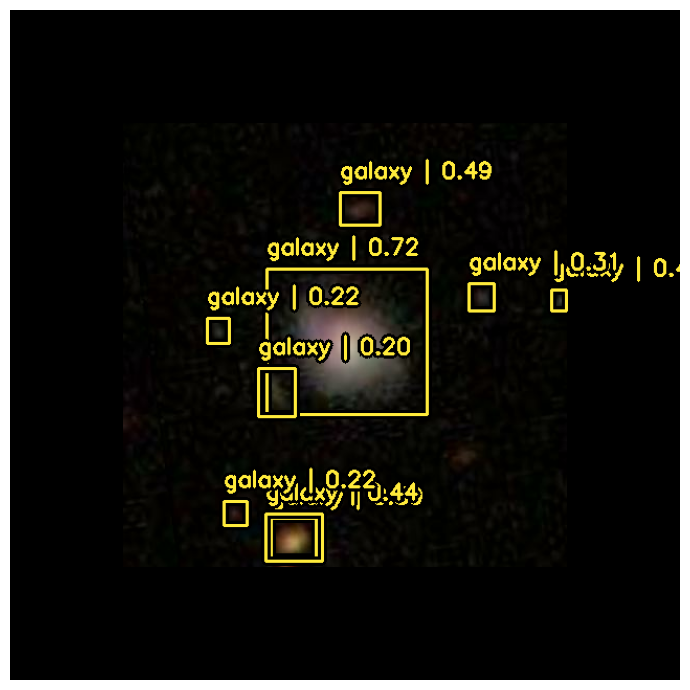

In [59]:
#Function to show galaxy detections in one test image
def visualize_detections_test(model, image):
    #Collect first batch of data from dataset
    image, y_true = image, None #Truth is None, since I didn't classify this image before

    #Predict boxes and classifications using trained model
    y_pred = model.predict(image)
    
    #Convert result to a dense tensor, for plot_bounding_box_gallery
    y_pred = bounding_box.to_dense(y_pred)

    #Use the visualization module plot_bounding_box_gallery
    visualization.plot_bounding_box_gallery(image, value_range=(0, 255), bounding_box_format='xyxy', y_true=y_true, y_pred=y_pred,
        scale=7, rows=1, cols=1, show=True, font_scale=0.7, class_mapping=class_mapping)

#Use on image
visualize_detections_test(yolo_model, image_model)

The model did a pretty good job - I think it missed only one galaxy in the bottom-right quadrant of the image. It also detected one of the galaxies twice.

Now I will select one of the detected galaxies and use GalSim to fit it with an ellipticity, as a demonstration of the process.

In [60]:
#Use model to find galaxies in the image
y_pred = yolo_model.predict(image_model)

#Get all of the predicted bounding boxes and their classifications
boxes = y_pred['boxes']

#Count the number of boxes
n_boxes = 0
for box in boxes[0]:
    if box[0] != -1:
        n_boxes+=1

#Select only galaxies, not stars
boxes = boxes[0][:n_boxes]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step


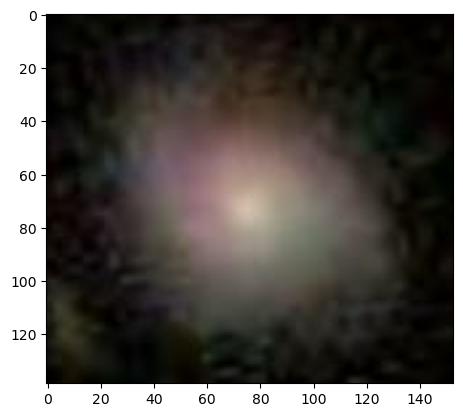

In [61]:
#Select the first box
testbox = boxes[0]
xmin, ymin, xmax, ymax = testbox #xyxy

#Show the part of the image in this box
galaxy = image[int(np.ceil(ymin)):int(np.ceil(ymax)), int(np.ceil(xmin)):int(np.ceil(xmax)), :]
plt.imshow(galaxy.numpy())

I will use the GalSim [FindAdaptiveMom](https://galsim-developers.github.io/GalSim/_build/html/hsm.html#galsim.hsm.FindAdaptiveMom) function. This function fits a grayscale image for an elliptical Gaussian - a combination of a Gaussian with some standard deviation, and a directional shear that causes the ellipticity. It begins with a circular Gaussian weight, then calculates the moments of the image and compares them to those of the Gaussian weight, and then adjusts the shear slightly and performs the same process iteratively until the weight moment matches that of the image. This gives values of the shear - ellipticity - which best transform a circular Gaussian into the image you provide.

First, I convert the cut-out image of the detected galaxy to grayscale:

In [62]:
#Function to convert color image to grayscale:
def grayscale(image):
    r, g, b = image[:,:,0], image[:,:,1], image[:,:,2] #grab R, G, and B components
    gray_image = 0.299 * r + 0.587 * g + 0.114 * b #Compute the weighted average
    return gray_image #Return grayscale image

#Convert cut-out galaxi image tensor to numpy array of 16-bit integers, then use function to convert to grayscale.
#I use 16-bit because this is the minimum required by GalSim 
image_array = grayscale(galaxy.numpy().astype("uint16") )


Then, I create a GalSim Image object with the grayscale image array, and run FindAdaptiveMom.

In [64]:
import galsim

#Make a GalSim Image object
galsim_image = galsim.Image(image_array)

#Run FindAdaptiveMom
ShapeData = galsim.hsm.FindAdaptiveMom(galsim_image)#, PSF_image=PSF_image)

To compare the best-fit galaxy shape to the cut-out galaxy image, I simulate an image of the GalSim galaxy. I create a galaxy model using arbitrary flux and radius values and an exponential light profile. Then, I shear the simulated galaxy by the best-fit shear amount found by FindAdaptiveMom.

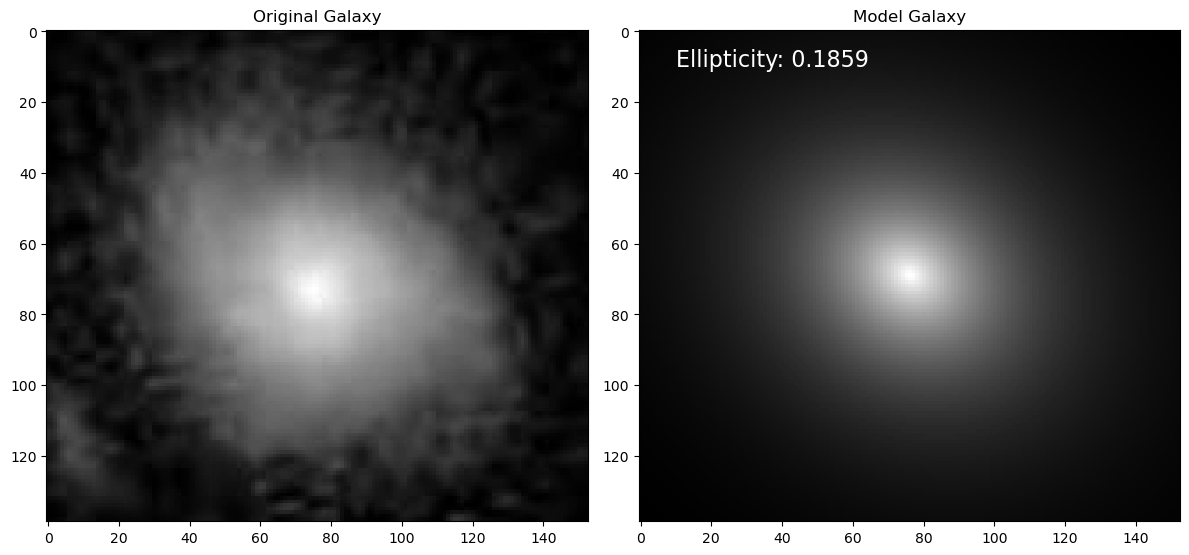

In [74]:
#Set up galaxy model; arbitrary flux and radius
flux = 100
scale_radius = 1.0  
#Assume an exponential light profile (for simplicity; I am more interested in the general shape)
galaxy_model = galsim.Exponential(flux=flux, scale_radius=scale_radius)

#Set up a shear model using the ellipticities that best fit the original galaxy cut-out image
shear_model = galsim.Shear(e1=ShapeData.observed_shape.e1, e2=ShapeData.observed_shape.e2)

#Shear the simulated galaxy
galaxy_model = galaxy_model.shear(shear_model)

#Create an image with the model galaxy
image_model_gal = galsim.ImageF(image_array.shape[1], image_array.shape[0])
galaxy_model.drawImage(image=image_model_gal, scale=0.04) #Scale is adjusted so the galaxy appears the right size in the image - no impact otherwise

#Set up plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), layout='tight')

#Plot the original image
ax1.imshow(image_array, cmap='gray')
ax1.set_title("Original Galaxy")

#Plot the model galaxy, with eccentricity fitted to OG image
ax2.imshow(image_model_gal.array, cmap='gray')
ax2.set_title("Model Galaxy")

#Display best-fit ellipticity on the image
ax2.text(10, 10, 'Ellipticity: %6.4f' %(shear_model.e), color='white', fontsize=16);

It looks like FindAdaptiveMom performed well! The shapes of the real and simulated galaxies look similar.

# Final Result: Application to Euclid Deep Field Image

For my final test of the model, I will complete my initial goal: applying my NN to detect galaxies in a Euclid Deep Field image, and then finding the eccentricity of each detected galaxy. I will use the [Fornax Deep Field image from Euclid Q1](https://euclid.caltech.edu/image/euclid20250319k-euclid-deep-field-fornax-preview). 

First, I will display the section of the image I will use. I am going to crop out a small part of it to use; in practice the model would be applied to each small section (sliding window method).

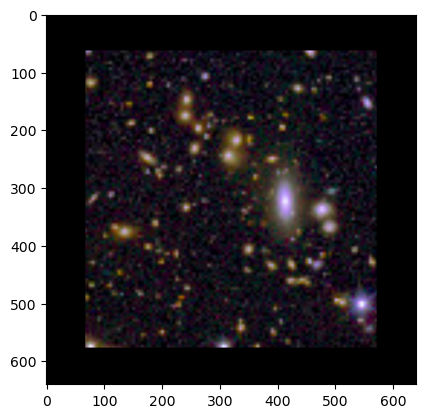

In [75]:
#Read in and convert image to useable format

image_path = 'EuclidDF_Fornax_Zoom.png'

image = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3) #Turn the image into a tensor
image = tf.image.resize_with_crop_or_pad(image, 640, 640) #Crop to 320x320
image_model = tf.reshape(image, (1, 640, 640, 3)) #Reshape into shape needed for model
plt.imshow(image) #Show the image

Next, I will run the NN on the image and display any galaxies it finds:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


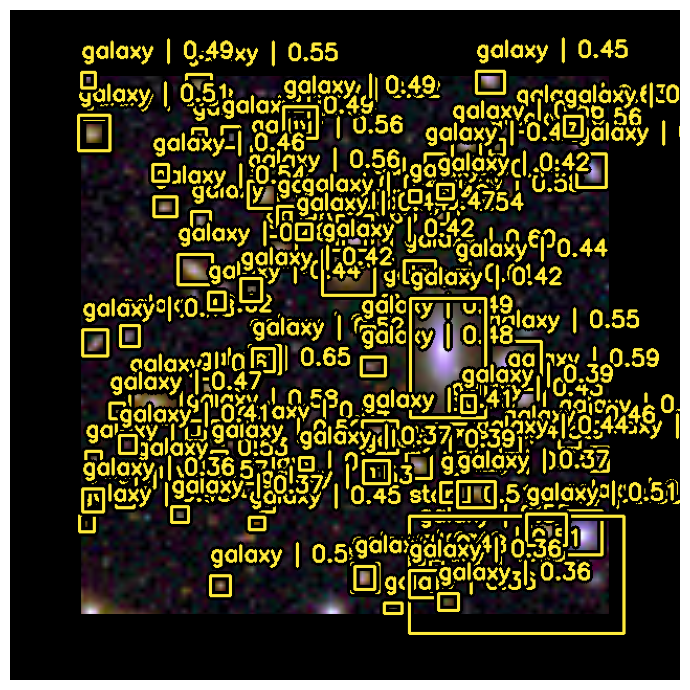

In [76]:
#Use model to find galaxies in the image
y_pred = yolo_model.predict(image_model)

#Select boxes
boxes = y_pred['boxes']

#Count the number of boxes
n_boxes = 0
for box in boxes[0]:
    if box[0] != -1:
        n_boxes+=1

#Select only galaxies, not stars
boxes = boxes[0][:n_boxes]

visualize_detections_test(yolo_model, image_model)

The model recovered a lot of galaxies in the image. There were some issues, however: there are a few galaxies, especially on the edges of the image, that were not correctly classified. There are also some very small galaxies, on the scale of a few pixels, that were not detected. There is at least one star (in the bottom right of the image) that was classified as a galaxy. 

Finally, for each detected galaxy, I will fit for the ellipticity and compare the real galaxy image with the simulated one. I 5 boxes here (picked this range to show a few elliptical ones):

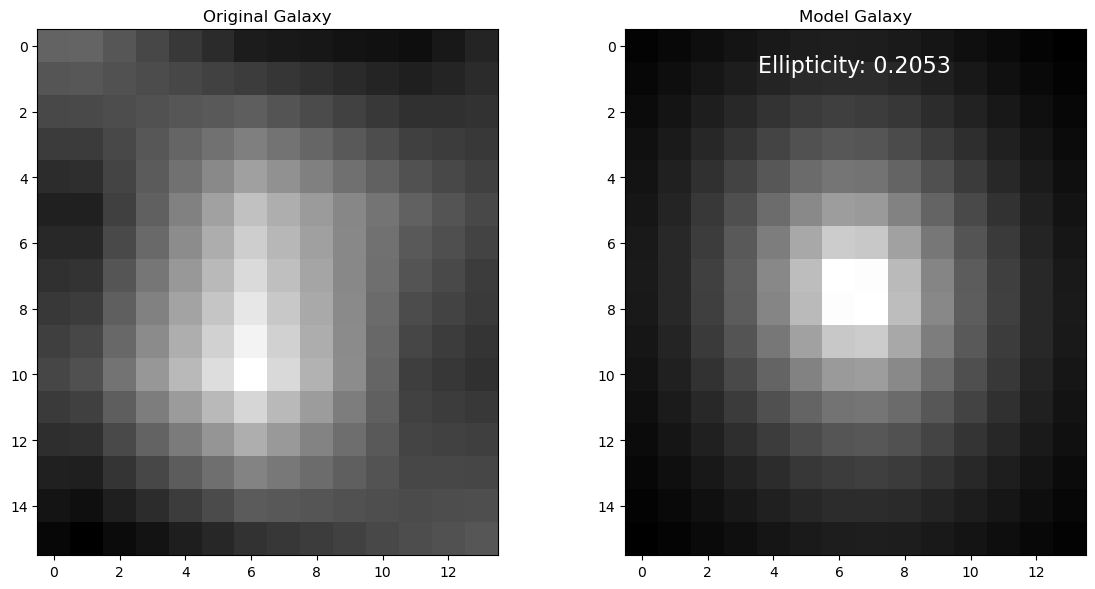

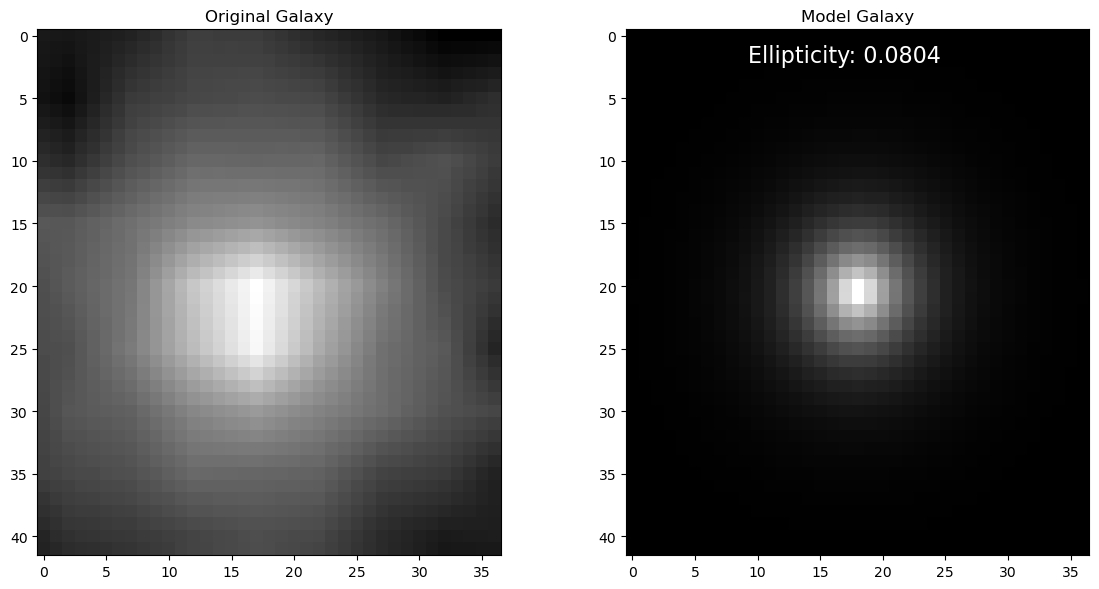

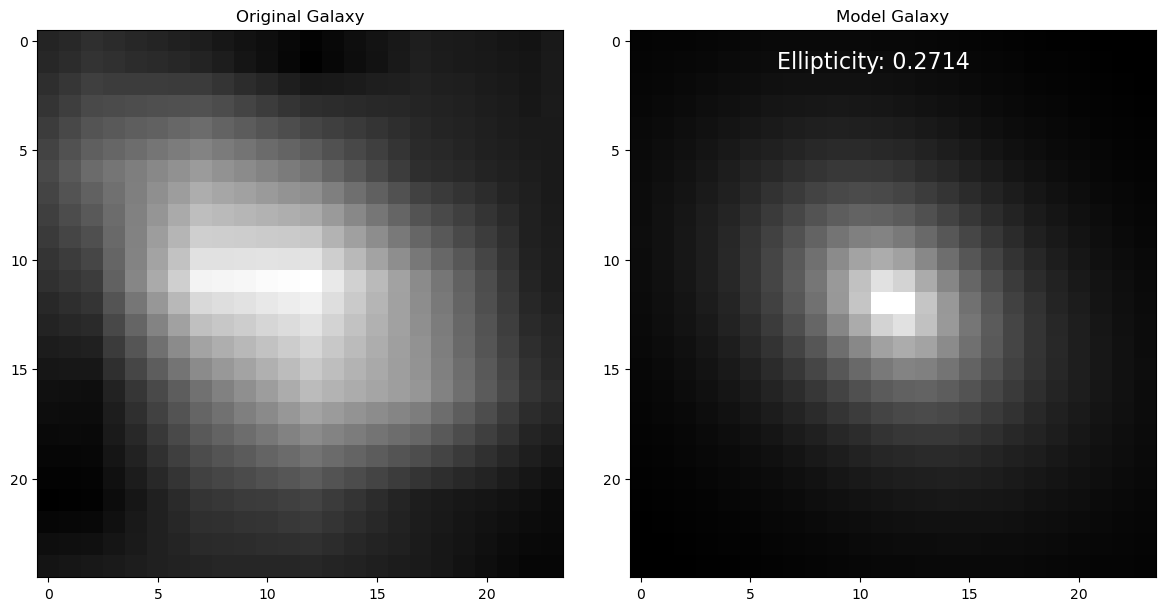

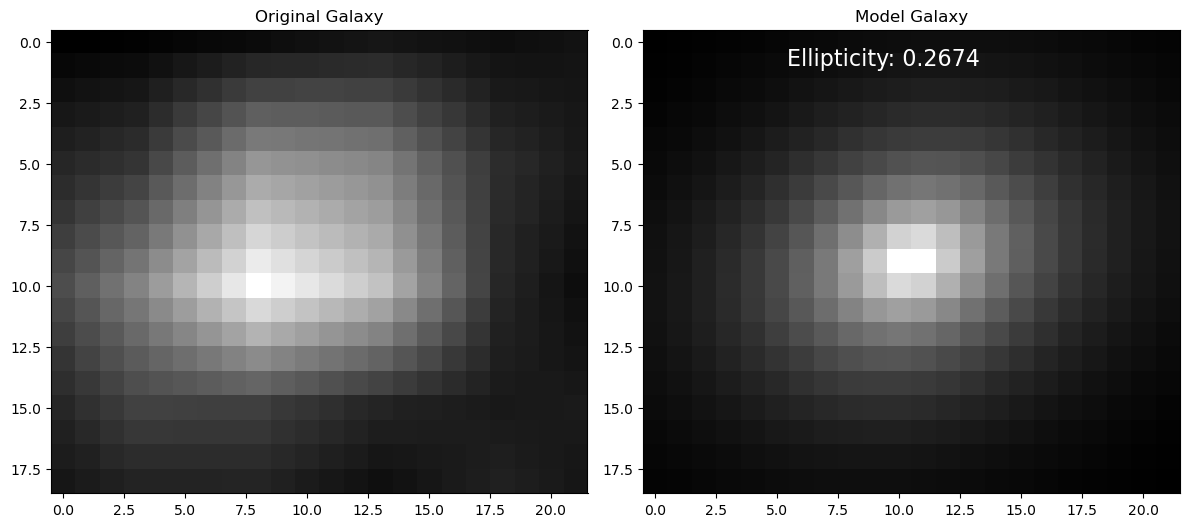

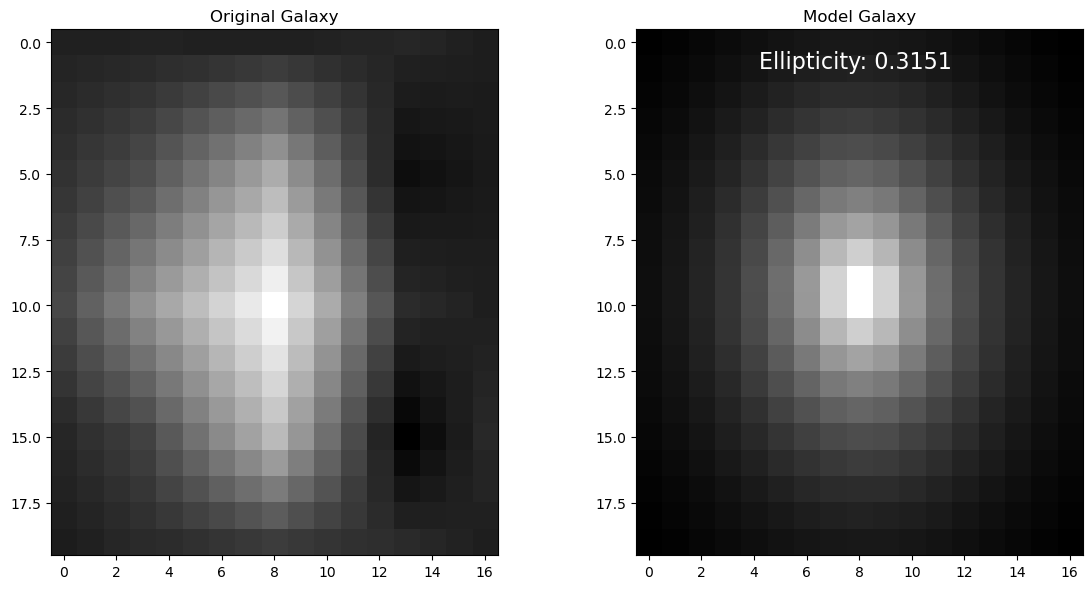

In [78]:
#Select some 5 for plotting
for box in boxes[35:40]:
    xmin, ymin, xmax, ymax = box #xyxy
    
    #Grab the part of the image in this box
    galaxy = image[int(np.ceil(ymin)):int(np.ceil(ymax)), int(np.ceil(xmin)):int(np.ceil(xmax)), :]

    #Make galaxy image grayscale
    image_array = grayscale(galaxy.numpy().astype("uint16") )

    #Make GalSim image and find adaptive moments
    galsim_image = galsim.Image(image_array)
    ShapeData = galsim.hsm.FindAdaptiveMom(galsim_image)#, PSF_image=PSF_image)

    #Set up arbitrary galaxy model
    flux = 100
    scale_radius = 1.0  
    #Assume an exponential light profile (for simplicity, I am more interested in the general shape)
    galaxy_model = galsim.Exponential(flux=flux, scale_radius=scale_radius)
    
    #Set up a shear model using the ellipticities that best fit the original galaxy cut-out image
    shear_model = galsim.Shear(e1=ShapeData.observed_shape.e1, e2=ShapeData.observed_shape.e2)
    
    #Shear the simulated galaxy
    galaxy_model = galaxy_model.shear(shear_model)
    
    #Create an image with the model galaxy
    image_model_gal = galsim.ImageF(image_array.shape[1], image_array.shape[0])
    galaxy_model.drawImage(image=image_model_gal)
    
    #Set up plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), layout='tight')
    
    #Plot the original image
    ax1.imshow(image_array, cmap='gray')
    ax1.set_title("Original Galaxy")
    
    #Plot the model galaxy, with eccentricity fitted to OG image
    ax2.imshow(image_model_gal.array, cmap='gray')
    ax2.set_title("Model Galaxy")
    
    #Display best-fit ellipticity on the image
    ax2.text(0.5*(xmax-xmin)/2, 0.1*(ymax-ymin)/2, 'Ellipticity: %6.4f' %(shear_model.e), color='white', fontsize=16)
    plt.show()

These simulated galaxies appear to match well with the detected galaxies, so I have a good estimate of ellipticity! It also looks like the model did a good job of cutting out galaxies without cutting them off at edges.

To use in a shear calculation, you would calculate the directional shear (e1 and e2) for each detected galaxy and then average them all. In practice, shear would be a function of area. Below, I perform a simplistic average of ellipticities in each direction to get the vertical and diagonal shear: 

In [89]:
#List for e1 (vertical)
e1_vals = []

#List for e2 (diagonal)
e2_vals = []

#List and integer for containing any errors when calculating adaptive moments
err_boxes = []
n_err = 0

for box in boxes: #For each box:
    xmin, ymin, xmax, ymax = box #xyxy
    
    #Grab the part of the image in this box
    galaxy = image[int(np.ceil(ymin)):int(np.ceil(ymax)), int(np.ceil(xmin)):int(np.ceil(xmax)), :]

    #Make galaxy image grayscale
    image_array = grayscale(galaxy.numpy().astype("uint16") )

    #Make GalSim image and find adaptive moments
    galsim_image = galsim.Image(image_array)

    #Try to calculate ellipticity. If it fails, add 1 to n_err and record the xmin of the box so it could be removed later
    try:
        ShapeData = galsim.hsm.FindAdaptiveMom(galsim_image)#, PSF_image=PSF_image)
    except: 
        n_err = n_err + 1
        print('Error finding ellipticities')
        err_boxes.append(xmin)

    #Append ellipticities
    e1_vals.append(ShapeData.observed_shape.e1)
    e2_vals.append(ShapeData.observed_shape.e2)

print('Number of galaxies for which ellipticity could not be found:', n_err)

print()
#Average in each direction
print('Average vertical shear:', np.average(e1_vals))
print('Average diagonal shear:', np.average(e2_vals))

Error finding ellipticities
Number of galaxies for which ellipticity could not be found: 1

Average vertical shear: -0.0033436637419799807
Average diagonal shear: 0.04317199189448729


# Conclusion

In this project, I have created a neural network which finds galaxies in images decently well, and set up architecture to find the ellipticities of each galaxy found in an image. While the model is imperfect and has a lot of room for improvement (for example, it misses some galaxies, misclassifies some stars/galaxies, selects some galaxies more than once, cuts off the edges of some galaxies), in general and as a proof-of-concept the model performs well. More work could be done to optimize the model and find the best hyperparameters, and to quantitatively evaluate the best-fit ellipticities.

I note that in my final image test, there was at least one star that the model classified as a galaxy. This issue may be due to the low prevalence of stars in my testing set - I could improve that by using some images with just stars rather than using only images that contained galaxies with maybe a few stars.